# Notebook for exploring claustrum data

### install and import essential packages and data

In [2]:
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

import scipy as sp
import scipy.io
import os
import numpy as np
import pandas as pd

from collections import Iterable
import matplotlib.pylab as mpl
%load_ext autoreload

mat = sp.io.loadmat('allUnitsLog_claus.mat')
mat2 = sp.io.loadmat('Opto_log_allUnits_claus.mat')
log = mat['fullLog']
log_df = pd.DataFrame(log, columns=['mouse_name', 'date', 'block_type', 'trial_type', 'touch_stimulus',\
                                    'vis_stimulus', 'response','trial_num', 'stim_onset', 'stim_offset', 'licks_right',\
                                    'licks_left', 'spike_times', 'cluster_name' ])
opto_log = mat2['fullOptoTable']
opto_log_df = pd.DataFrame(opto_log, columns=['mouse_name', 'date', 'cluster_name', 'opto_stim_onsets', 'opto_stim_offsets', 'spikes'])

In [3]:
mat3 = sp.io.loadmat('waveform_log.mat')

In [4]:
waveforms = mat3['waveform_log']
waveforms_df = pd.DataFrame(waveforms, columns = ['mouse_name', 'date', 'tetrode_num', 'spikes', 'waveforms'])

waveforms_df.head(3)

,mouse_name,date,tetrode_num,spikes,waveforms
0,[Claustrum3],[03-16-17],[TT1],"[[2927.20496667], [2927.56466667], [2927.65263...","[[[-0.00311364419642, -0.00138941349112, -0.00..."
1,[Claustrum3],[03-16-17],[TT2],"[[2927.18636667], [2927.1987], [2927.2731], [2...","[[[-0.00171621958259, -0.00151926855499, -0.02..."
2,[Claustrum3],[03-16-17],[TT3],"[[2927.46876667], [2927.64306667], [2927.65383...","[[[-0.00159455783317, 0.00676095524841, 0.0033..."


### clean up data tables

In [5]:
for col in [0,1,2,3,4,5,6,6,7,7,7,7,8,8,8,8,9,9,9,9,10,10,11,11,13]:
        log_df.ix[:,col] = log_df.ix[:,col].str[0]
for col in [0,1,2,3,4]:
        opto_log_df.ix[:,col] = opto_log_df.ix[:,col].str[0]
for col in [0,1,2]:
    waveforms_df.ix[:,col] = waveforms_df.ix[:,col].str[0]
    


In [6]:
waveforms_df['spikes']= waveforms_df['spikes'].apply(lambda y: np.concatenate(y) if len(y) > 0 else y)
log_df['spike_times'] = log_df['spike_times'].apply(lambda y: np.concatenate(y) if len(y) > 0 else y)
opto_log_df['spikes'] = opto_log_df['spikes'].apply(lambda y: np.concatenate(y) if len(y) > 0 else y)

In [7]:
log_df.head(2)

,mouse_name,date,block_type,trial_type,touch_stimulus,vis_stimulus,response,trial_num,stim_onset,stim_offset,licks_right,licks_left,spike_times,cluster_name
0,Claustrum3,03-16-17,Visual,Stim_Som_NoCue,SineAmp0p925Freq20Cyc3,Amp0p5Dur0p150,0,3,1.4482,1.595667,[],[],"[0.0117666666667, 0.0321666666667, 0.110466666...",TT1clst1
1,Claustrum3,03-16-17,Visual,Stim_Som_NoCue,SineAmp0p925Freq20Cyc3,Amp0p5Dur0p150,0,3,1.4482,1.595667,[],[],"[0.155366666667, 0.355766666667, 1.54956666667...",TT1clst2


In [8]:
opto_log_df.head(2)

,mouse_name,date,cluster_name,opto_stim_onsets,opto_stim_offsets,spikes
0,Claustrum3,03-16-17,TT1clst1,"[3964.30126667, 3964.80126667, 3965.30126667, ...","[3964.55126667, 3965.05126667, 3965.5513, 3966...","[3939.5548, 3939.7151, 3939.9379, 3940.725, 39..."
1,Claustrum3,03-16-17,TT1clst2,"[3964.30126667, 3964.80126667, 3965.30126667, ...","[3964.55126667, 3965.05126667, 3965.5513, 3966...","[3939.7038, 3939.994, 3940.2059, 3940.539, 394..."


In [9]:
waveforms_df.head(5)

,mouse_name,date,tetrode_num,spikes,waveforms
0,Claustrum3,03-16-17,TT1,"[2927.20496667, 2927.56466667, 2927.65263333, ...","[[[-0.00311364419642, -0.00138941349112, -0.00..."
1,Claustrum3,03-16-17,TT2,"[2927.18636667, 2927.1987, 2927.2731, 2927.285...","[[[-0.00171621958259, -0.00151926855499, -0.02..."
2,Claustrum3,03-16-17,TT3,"[2927.46876667, 2927.64306667, 2927.65383333, ...","[[[-0.00159455783317, 0.00676095524841, 0.0033..."
3,Claustrum3,03-16-17,TT4,"[2927.10336667, 2927.14666667, 2927.17603333, ...","[[[0.00348502904712, 0.00601324283246, -0.0032..."
4,Claustrum3,03-16-17,TT5,"[2926.0951, 2926.85366667, 2927.07906667, 2927...","[[[0.00127071695839, 0.00276057371034, 0.01954..."


In [10]:
clusters = opto_log_df['cluster_name'].copy()
clusters = clusters.apply(lambda y: y[:3])

opto_log_df['waveforms'] = np.nan
opto_log_df['waveforms'] = opto_log_df['waveforms'].astype(object)
for unit in range(len(opto_log_df)):
    tetrode_idx = pd.concat((opto_log_df.loc[unit,['mouse_name', 'date']] == waveforms_df[['mouse_name', 'date']],
           clusters[unit] == waveforms_df['tetrode_num']), axis = 1).all(axis = 1)
    tetrode = waveforms_df[tetrode_idx]
    
    spike_idx = np.in1d(np.around(tetrode['spikes'].iloc[0],4),  np.around(opto_log_df.loc[unit, 'spikes'],4))
    wv = tetrode['waveforms'].iloc[0][spike_idx]
    opto_log_df.loc[unit,'waveforms'] = wv

In [11]:
opto_log_df['waveforms1'] = np.nan
opto_log_df['waveforms2'] = np.nan
opto_log_df['waveforms3'] = np.nan
opto_log_df['waveforms4'] = np.nan

opto_log_df['waveforms1'] = opto_log_df['waveforms'].apply(lambda y: y[:,0,:])
opto_log_df['waveforms2'] = opto_log_df['waveforms'].apply(lambda y: y[:,1,:])
opto_log_df['waveforms3'] = opto_log_df['waveforms'].apply(lambda y: y[:,2,:])
opto_log_df['waveforms4'] = opto_log_df['waveforms'].apply(lambda y: y[:,3,:])
del opto_log_df['waveforms']

### sort optogenetic stimulus pulses into groups based on frequency of stimulation

In [12]:
unique_sessions = opto_log_df[['mouse_name', 'date']].drop_duplicates()

opto_log_df['first_last_opto_pulses'] = np.nan
opto_log_df['grouped_opto_pulses'] = np.nan

for session in range(unique_sessions.shape[0]):
    session_row_ind = (opto_log_df.loc[:,['mouse_name', 'date']] == unique_sessions.iloc[session]).all(axis=1)
    rows = opto_log_df.loc[session_row_ind]
    
    ISIs = np.around(rows.iloc[0,3][1:]-rows.iloc[0,3][0:-1], 4)
    ISIs = np.concatenate(([ISIs[0]], ISIs, [ISIs[-1]]))
    unique_ISIs = np.unique(ISIs, return_counts = True)
    ind = unique_ISIs[1]>50
    unique_ISIs = unique_ISIs[0][ind]

    first_last_opto_pulses = {}
    grouped_opto_pulses = {}
    for isi in unique_ISIs:
        ISI_category = np.where(np.absolute(ISIs-isi) <= 0.001)[0]
        opto_pulse_inds= np.array(range(np.min(ISI_category),np.max(ISI_category)))
        grouped_opto_pulses[1/isi] = rows.iloc[0,3][opto_pulse_inds]

        IBI_ind = ISIs[opto_pulse_inds] != isi
        first_pulse_ind = np.concatenate(([opto_pulse_inds[0]],opto_pulse_inds[IBI_ind]))
        last_pulse_ind = np.concatenate((first_pulse_ind[1:]-1, [opto_pulse_inds[-1]]))
        first_last_opto_pulses[1/isi] = [rows.iloc[0,3][first_pulse_ind],rows.iloc[0,3][last_pulse_ind]]
    opto_log_df.loc[session_row_ind,'first_last_opto_pulses'] = [first_last_opto_pulses]
    opto_log_df.loc[session_row_ind,'grouped_opto_pulses'] = [grouped_opto_pulses]

In [13]:
opto_log_df.head(3)

,mouse_name,date,cluster_name,opto_stim_onsets,opto_stim_offsets,spikes,waveforms1,waveforms2,waveforms3,waveforms4,first_last_opto_pulses,grouped_opto_pulses
0,Claustrum3,03-16-17,TT1clst1,"[3964.30126667, 3964.80126667, 3965.30126667, ...","[3964.55126667, 3965.05126667, 3965.5513, 3966...","[3939.5548, 3939.7151, 3939.9379, 3940.725, 39...","[[-0.00569385901328, 0.00427144877455, 0.01036...","[[-0.000308106460985, -0.000802925028194, 0.00...","[[-0.00450201920227, 0.00326803521214, 0.01496...","[[0.00304913531746, -0.00919101903591, -0.0032...","{40.0: [[4431.20513333, 4437.7807, 4444.389566...","{40.0: [4431.20513333, 4431.23013333, 4431.255..."
1,Claustrum3,03-16-17,TT1clst2,"[3964.30126667, 3964.80126667, 3965.30126667, ...","[3964.55126667, 3965.05126667, 3965.5513, 3966...","[3939.7038, 3939.994, 3940.2059, 3940.539, 394...","[[0.0152626581353, 0.00515087438445, 0.0032498...","[[0.00727499412866, 0.0109553912154, 0.0019511...","[[0.0257969085223, 0.00709416862995, -0.009436...","[[0.00739895471209, 0.00369916295709, -0.00722...","{40.0: [[4431.20513333, 4437.7807, 4444.389566...","{40.0: [4431.20513333, 4431.23013333, 4431.255..."
2,Claustrum3,03-16-17,TT2clst1,"[3964.30126667, 3964.80126667, 3965.30126667, ...","[3964.55126667, 3965.05126667, 3965.5513, 3966...","[3939.6048, 3939.6874, 3939.7985, 3939.9973, 3...","[[0.00601039856621, -0.00313941386955, -0.0053...","[[-0.00359154860615, -0.00598855578644, -0.010...","[[0.0171037877991, 0.0231573410048, 0.01245641...","[[0.000228362000035, 0.0189635602555, 0.010026...","{40.0: [[4431.20513333, 4437.7807, 4444.389566...","{40.0: [4431.20513333, 4431.23013333, 4431.255..."


### plot spike rasters for optogenetic stimulus trials
#### define function that will plot rasters

In [14]:
import matplotlib.patches as patches
from matplotlib import gridspec
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}

mpl.rc('font', **font)
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16)
mpl.rc('axes', labelsize=18)

    

def opto_identify(unit_num, log):
    
    unit = opto_log_df.iloc[unit_num]


    mpl.close('all')
    fig = mpl.figure(figsize=(15, 8))
    fig.suptitle(unit['mouse_name'] + ', ' +  unit['date'] + ', ' + unit['cluster_name'])
    gs = gridspec.GridSpec(5, 2, height_ratios=[1, 15, 5, 1, 15]) 
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[6])
    ax4 = fig.add_subplot(gs[7])

    rs1 = fig.add_subplot(gs[2])
    rs2 = fig.add_subplot(gs[3])
    rs3 = fig.add_subplot(gs[8])
    rs4 = fig.add_subplot(gs[9])

    rasters = [rs1, rs2, rs3, rs4]
    opto_axes = [ax1, ax2, ax3, ax4]
    frequencies = [1,5,10,40]

    for i, frequency in enumerate(frequencies):
        flop = unit['first_last_opto_pulses'][frequency]

        trial_dur = flop[1][0] - flop[0][0]
        trial_total = 0
        for trial in range(len(flop[0])):
            trial_spike_inds = (flop[0][trial]-0.5 < unit['spikes']) & (unit['spikes'] < flop[1][trial]+.5)
            trial_spikes = unit['spikes'][trial_spike_inds] - flop[0][trial]
            rasters[i].vlines(trial_spikes, trial + .5, trial + 1.3, linewidth = 0.5)
            trial_total += 1

        figure_pulse_inds = [(unit['grouped_opto_pulses'][frequency] >= flop[0][1])
                  & (unit['grouped_opto_pulses'][frequency] <= flop[1][1])]
        figure_pulses = unit['grouped_opto_pulses'][frequency][figure_pulse_inds] - flop[0][1]
        example_pulse_ind = np.where(unit['opto_stim_onsets'] == flop[0][1])
        stim_duration = unit['opto_stim_offsets'][example_pulse_ind] - unit['opto_stim_onsets'][example_pulse_ind]

        for p in figure_pulses:
            opto_axes[i].add_patch(patches.Rectangle((p,0), stim_duration*5, 4, color = 'xkcd:sky blue')) 

        rasters[i].autoscale(enable=True, tight=True)
        rasters[i].spines['right'].set_visible(False)
        rasters[i].spines['top'].set_visible(False)
        rasters[i].xaxis.set_ticks_position('bottom')
        rasters[i].yaxis.set_ticks_position('left')
        rasters[i].set_xlim(-trial_dur*0.1, trial_dur + trial_dur*0.1)
        rasters[i].set_xlabel('Time(s)')
        rasters[i].set_ylabel('Trials')

        opto_axes[i].set_ylim(0, 4, )
        opto_axes[i].set_xlim(-trial_dur*0.1, trial_dur + trial_dur*0.1 )
        opto_axes[i].axis('off')
        opto_axes[i].set_title(str(frequency) + ' Hz')

    mpl.subplots_adjust(left=0.1, right=.9, top=0.9, bottom=0.1)

    return fig

#### create widget that will make exploring data easier - drag slider to switch between units

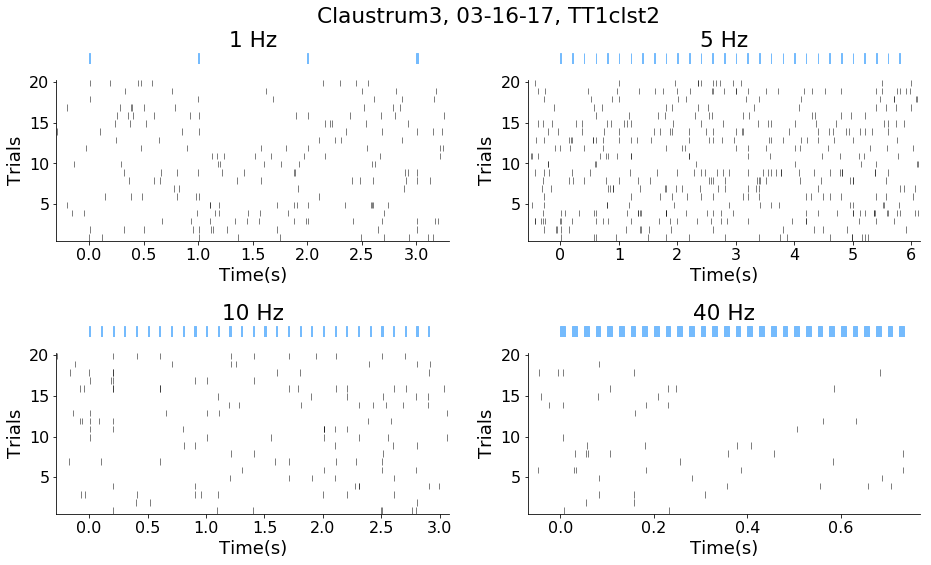

In [15]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.html import widgets
from IPython.display import display
import traitlets

log = opto_log_df
unit_num = 12
num = widgets.IntSlider(min = 1, max = opto_log_df.shape[0], step = 1, width='75%', height='30px', 
                    description= "Unit", continuous_update=False)
s = interactive(opto_identify, unit_num = num, log = fixed(log), continuous_update=False)
display(s)

### plot reliability and latency of optogenetic responses
#### define function that will  for each unit

In [27]:
import seaborn as sns
sns.set_style("ticks")

def opto_metrics(unit_num, log):

    unit = opto_log_df.iloc[unit_num]
    frequencies = [1,5,10,40]
    stim_duration = 0.002

    mpl.close('all')
    fig2 = mpl.figure(figsize=(18, 10))
    fig2.suptitle(unit['mouse_name'] + ', ' +  unit['date'] + ', ' + unit['cluster_name'])


    ax1 = mpl.subplot2grid((2,2), (0,0), rowspan=2, colspan=1)
    ax2 = mpl.subplot2grid((2,2), (0,1), rowspan=1, colspan=1)
    ax3 = mpl.subplot2grid((2,2), (1,1), rowspan=1, colspan=1)

    ax4 = fig2.add_axes([0.35, 0.425, 0.1, 0.4])


    data={}
    total_stims = 0

    first_pulse = np.min(np.concatenate(list(unit['grouped_opto_pulses'].values())))
    last_pulse = np.max(np.concatenate(list(unit['grouped_opto_pulses'].values())))
    cont_spike_inds = (unit['spikes'] < first_pulse) | (unit['spikes'] > last_pulse)
    laser_evoked_spike_inds = []
    for freq in frequencies:
        opto_stims = unit['grouped_opto_pulses'][freq]
        for stim_num in range(90):
            spike_inds = (unit['spikes'] >= opto_stims[stim_num]-0.01) & (unit['spikes'] < opto_stims[stim_num] + .02)
            spikes = (unit['spikes'][spike_inds] - opto_stims[stim_num])*1000
            ax1.vlines(spikes, total_stims + stim_num + .5, total_stims + stim_num + 1.3, linewidth = 2)
            x = total_stims+stim_num

            new_laser_evoked_spike_inds = np.where((unit['spikes'] >= opto_stims[stim_num]) & 
            (unit['spikes'] <= opto_stims[stim_num] + .01))[0]
            laser_evoked_spike_inds = np.concatenate((laser_evoked_spike_inds, new_laser_evoked_spike_inds))

        ax1.plot([0,stim_duration*1000], [total_stims+stim_num, total_stims+stim_num], color = 'k', linewidth = 3)
        ax1.text(-2, total_stims + stim_num/2, str(freq) + ' Hz', fontsize = 13),
        total_stims = total_stims + stim_num

        spikes = unit['spikes']
        idx = spikes.searchsorted(opto_stims, side = 'right')
        latencies = spikes[idx] - opto_stims
        data[freq] = latencies[0:]

    offset = 0
    waveform_corr = []
    for electrode in range(4):
        laser_evoked_waveforms_df = pd.DataFrame(unit.iloc[electrode+6][laser_evoked_spike_inds.astype(int)]).mean()+offset
        cont_waveforms_df = pd.DataFrame(unit.iloc[electrode+6][cont_spike_inds]).mean()+offset
        waveform_corr.append(sp.stats.pearsonr(laser_evoked_waveforms_df, cont_waveforms_df)[0])
        ax4.plot(cont_waveforms_df, color = 'k', alpha = 0.8, linewidth = 3)
        ax4.plot(laser_evoked_waveforms_df, color = 'xkcd:sky blue',alpha = 0.8, linewidth = 3)
        sns.despine()
        offset += 0.2
    waveform_corr = np.around(np.mean(waveform_corr),2)
    ax4.set_title('r = ' + str(waveform_corr), fontsize = 14)


    values = np.concatenate(list(data.values()))
    labels = np.concatenate([[freq] * len(data[freq]) for freq in data.keys()])
    data_df = pd.DataFrame([values, labels])
    data_df=data_df.T
    data_df.columns = ['values', 'labels']
    data_df['values'] = data_df['values']*1000


    data_df['reliability'] = 0 
    light_evoked_spike = data_df['values'] <= 10
    data_df.loc[light_evoked_spike, 'reliability'] = 1
    sns.pointplot(x = 'labels', y = 'reliability', data = data_df, ax=ax2, join = False, color = 'xkcd:sky blue')


    light_evoked_df = data_df[data_df['values'] <= 10]
    sns.violinplot(x = 'labels', y = 'values', data = light_evoked_df, ax=ax3, color = 'xkcd:sky blue')

    ax1.set_xlabel('Time(ms)')
    ax1.set_ylabel('Stim trial')
    ax1.autoscale(enable=True, tight=True)
    ax1.xaxis.set_ticks_position('bottom')
    ax1.yaxis.set_ticks_position('left')
    ax1.add_patch(patches.Rectangle((0,0), stim_duration*1000, total_stims, color = 'xkcd:sky blue'))
    ax1.set_xlim(-7.5,20)

    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_ylabel('Mean spike latency (ms)')
    ax3.set_ylim(0,20)
    ax3.yaxis.set_ticks(np.arange(0, 20, 2.5))

    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('P(spike)')
    ax2.set_ylim(0,1)

    ax4.patch.set_alpha(0)
    ax4.axis('off')

    ax5 = fig2.add_axes([0.41, 0.40, 0.05, 0.1])
    ax5.spines['left'].set_visible(False)
    ax5.spines['top'].set_visible(False)
    ax5.yaxis.set_ticks_position('right')
    ax5.spines['right'].set_smart_bounds(True)
    ax5.spines['bottom'].set_smart_bounds(True)
    mpl.yticks((0,0.2,0.2), fontsize = 13)
    mpl.xticks((0,0.5,0.5), fontsize = 13)
    ax5.set_ylim(0,0.2)
    ax5.set_xlim(0,0.5)
    ax5.patch.set_alpha(0)
    ax5.set_xlabel('ms',fontsize = 13)
    ax5.set_ylabel('mV',fontsize = 13)
    ax5.yaxis.set_label_position('right')

    return fig2

#### create widgets to make exploring data easier

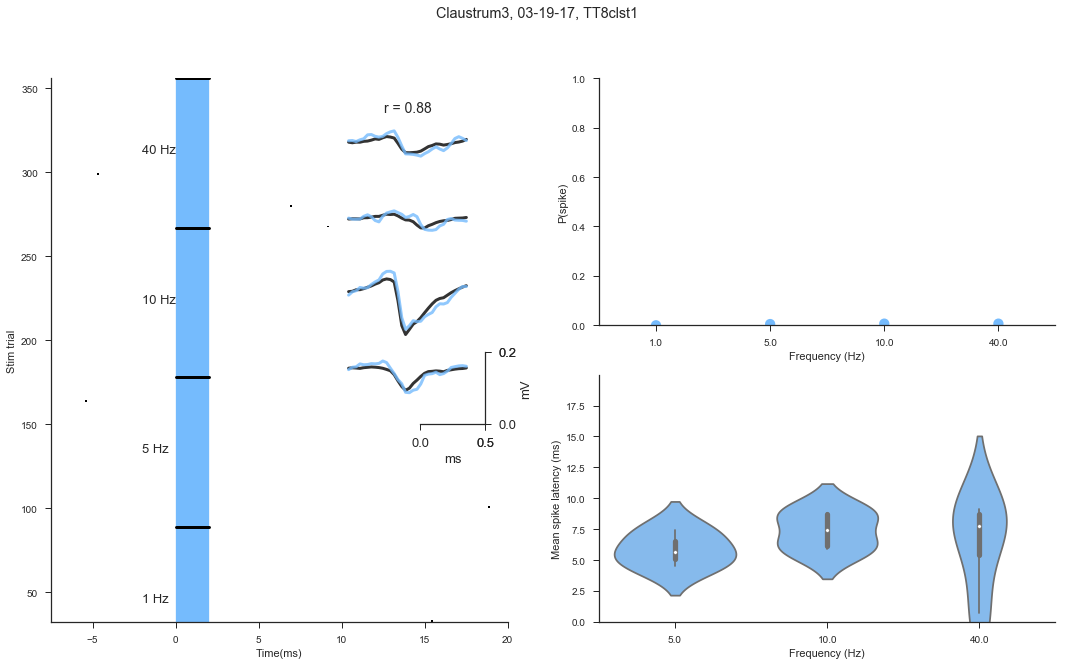

In [28]:
num = widgets.IntSlider(min = 1, max = opto_log_df.shape[0], step = 1, width='75%', height='30px', 
                    description= "Unit", continuous_update=False)
s = interactive(opto_metrics, unit_num = num, log = fixed(log), continuous_update=False)
display(s)

In [42]:
unit['grouped_opto_pulses'].items()

dict_items([(40.0, array([ 3186.53283333,  3186.55783333,  3186.58283333,  3186.60783333,
        3186.63283333,  3186.65783333,  3186.68283333,  3186.70783333,
        3186.73283333,  3186.75783333,  3186.78283333,  3186.80783333,
        3186.83283333,  3186.85783333,  3186.88283333,  3186.90783333,
        3186.93283333,  3186.95783333,  3186.98283333,  3187.00783333,
        3187.03283333,  3187.05783333,  3187.08283333,  3187.10783333,
        3187.13283333,  3187.15783333,  3187.18283333,  3187.20783333,
        3187.23283333,  3193.11976667,  3193.14476667,  3193.16976667,
        3193.19476667,  3193.21976667,  3193.24476667,  3193.26976667,
        3193.29476667,  3193.31976667,  3193.34476667,  3193.36976667,
        3193.39476667,  3193.41976667,  3193.44476667,  3193.46976667,
        3193.49476667,  3193.51976667,  3193.54476667,  3193.56976667,
        3193.59476667,  3193.61976667,  3193.64476667,  3193.66976667,
        3193.69476667,  3193.71976667,  3193.74476667,  31

In [147]:
unit = opto_log_df.iloc[6]
first_pulse = np.min(np.concatenate(list(unit['grouped_opto_pulses'].values())))
first_pulse
frequencies = [1,5,10,40]
stim_duration = 0.002
unit['grouped_opto_pulses']
opto_windows_df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in unit['grouped_opto_pulses'].items()]))
del opto_windows_df[2]
names = [str(freq) + 'end' for freq in frequencies]
evoked_spike_inds_df = opto_windows_df.applymap(lambda y: np.where((y <= unit['spikes']) & (y+0.01>= unit['spikes']))[0]) 

opto_metrics_df = {}
for freq in frequencies:
    opto_metrics_df[freq] = [np.concatenate(evoked_spike_inds_df[freq].as_matrix())]
pd.DataFrame(opto_metrics_df)
spikes = unit['spikes']
    idx = spikes.searchsorted(opto_stims, side = 'right')
    latencies = spikes[idx] - opto_stims
    data[freq] = latencies[0:]


C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: invalid value encountered in greater_equal
C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: invalid value encountered in less_equal


,1,5,10,40
0,"[1390, 1393, 1402, 1407, 1432, 1433, 1435, 144...","[674, 675, 676, 677, 678, 679, 680, 681, 682, ...","[338, 339, 340, 342, 343, 344, 345, 346, 347, ...","[1066, 1067, 1068, 1069, 1070, 1071, 1081, 108..."


In [32]:

data={}
total_stims = 0

first_pulse = np.min(np.concatenate(list(unit['grouped_opto_pulses'].values())))
last_pulse = np.max(np.concatenate(list(unit['grouped_opto_pulses'].values())))
cont_spike_inds = (unit['spikes'] < first_pulse) | (unit['spikes'] > last_pulse)
laser_evoked_spike_inds = []

for freq in frequencies:
    opto_stims = unit['grouped_opto_pulses'][freq]
    opto_windows_df = pd.DataFrame({'start': opto_stims, 'stop': opto_stims+0.01})    
        
        
    for stim_num in range(90):
        spike_inds = (unit['spikes'] >= opto_stims[stim_num]-0.01) & (unit['spikes'] < opto_stims[stim_num] + .02)
        spikes = (unit['spikes'][spike_inds] - opto_stims[stim_num])*1000
        ax1.vlines(spikes, total_stims + stim_num + .5, total_stims + stim_num + 1.3, linewidth = 2)
        x = total_stims+stim_num

        new_laser_evoked_spike_inds = np.where((unit['spikes'] >= opto_stims[stim_num]) & 
        (unit['spikes'] <= opto_stims[stim_num] + .01))[0]
        laser_evoked_spike_inds = np.concatenate((laser_evoked_spike_inds, new_laser_evoked_spike_inds))

    spikes = unit['spikes']
    idx = spikes.searchsorted(opto_stims, side = 'right')
    latencies = spikes[idx] - opto_stims
    data[freq] = latencies[0:]

offset = 0
waveform_corr = []
for electrode in range(4):
    laser_evoked_waveforms_df = pd.DataFrame(unit.iloc[electrode+6][laser_evoked_spike_inds.astype(int)]).mean()+offset
    cont_waveforms_df = pd.DataFrame(unit.iloc[electrode+6][cont_spike_inds]).mean()+offset
    waveform_corr.append(sp.stats.pearsonr(laser_evoked_waveforms_df, cont_waveforms_df)[0])

    sns.despine()
    offset += 0.2
waveform_corr = np.around(np.mean(waveform_corr),2)

values = np.concatenate(list(data.values()))
labels = np.concatenate([[freq] * len(data[freq]) for freq in data.keys()])
data_df = pd.DataFrame([values, labels])
data_df=data_df.T
data_df.columns = ['values', 'labels']
data_df['values'] = data_df['values']*1000


data_df['reliability'] = 0 
light_evoked_spike = data_df['values'] <= 10
data_df.loc[light_evoked_spike, 'reliability'] = 1


light_evoked_df = data_df[data_df['values'] <= 10]

AttributeError: 'list' object has no attribute 'astype'

NameError: name 'nan' is not defined

In [104]:
np.nan

nan